# Splitting approximation error

In [1]:
# ======= Libraries =======
import jax.numpy as jnp
import jax.random
import math
from jax import jit, vmap, grad
from jax.numpy.linalg import qr
from jax.scipy.linalg import expm
from jax.numpy.linalg import pinv
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import numpy as np
RNG = jax.random.PRNGKey(0)

# ======= Helper functions =======
def generate_problem(p, n, b, lstsq=False, epsilon=0, key=RNG):
    # Generate the main problem data
    X = jax.random.normal(key, (n, p))
    theta_clean = jnp.ones(p)
    y = X @ theta_clean + epsilon * jax.random.normal(key, (n,))
    init_bound = 1.0 / math.sqrt(p)
    theta_0 = init_bound * jax.random.uniform(key, (p,), minval=-1, maxval=1)

    # Split data into batches (ignoring the remainder if n is not divisible by b)
    m = n // b  # Number of full batches
    Xs = jnp.array([X[i * b:(i + 1) * b, :] for i in range(m)])
    ys = jnp.array([y[i * b:(i + 1) * b] for i in range(m)])

    @jit
    def QR_dataset(Xs):
        # Perform QR decomposition for each batch
        Qs = jnp.array([qr(X_batch.T, mode='reduced')[0] for X_batch in Xs])
        Rs = jnp.array([qr(X_batch.T, mode='reduced')[1] for X_batch in Xs])
        return Qs, Rs

    Qs, Rs = QR_dataset(Xs)
    # Compute least squares solution if requested
    theta_lstsq = jnp.linalg.lstsq(X, y, rcond=None)[0] if lstsq else None

    # Store everything in a dictionary
    problem = {
        "Xs": Xs,
        "ys": ys,
        "Qs": Qs,
        "Rs": Rs,
        "X": X,
        "theta_0": theta_0,
        "theta_lstsq": theta_lstsq,
        "y": y,
        "n": n,
        "b": b,
        "p": p,
        "m": m
    }

    return problem

@jit
def solve_local_problem(h, local_problem):
    # Using pinv by default as JAX does not support exceptions in JIT-compiled functions
    Q, R, theta_0, y, n = local_problem["Q"], local_problem["R"], \
        local_problem["theta_0"], local_problem["y"], local_problem["n"],
    
    R_it = pinv(R.T)
    exp_m = expm(-2 / n * R @ R.T * h)

    return Q @ (exp_m @ (Q.T @ theta_0 - R_it @ y)) + Q @ (R_it @ y) + theta_0 - Q @ (Q.T @ theta_0)

@jit
def function_value(X, theta, y, n):
    return 1/n * jnp.linalg.norm(X @ theta - y)**2

@jit
def gradient_norm(X, theta, y, n):
    gradient = 2/n * X.T @ (X @ theta - y)
    return jnp.linalg.norm(gradient)

@jit
def relative_error(theta, theta_exact):
    return jnp.linalg.norm(theta - theta_exact) / jnp.linalg.norm(theta_exact)

# ======= Experiment design =======

# Example usage
p = 30  # Number of parameters
n = 200  # Number of samples
b = 20   # Batch size

problem = generate_problem(p, n, b, lstsq=True, epsilon=0)

methods = ["Splitting I", "Splitting II"]
errs = dict.fromkeys(methods)

# ======= Experiment =======

Q, R = qr(problem["X"].T, mode='reduced')

global_problem = {
    "X": problem["X"],
    "y": problem["y"],
    "Q": Q,
    "R": R,
    "theta_0": problem["theta_0"],
    "n": problem["n"]
    }

# Vectorizing the solve_local_problem function over timestamps
v_solve_local_problem = vmap(solve_local_problem, in_axes=(0, None))
v_relative_error = vmap(relative_error, in_axes=(0, None))

# Calculate thetas for all timestamps in one go
hs = jnp.logspace(-5, 1)
n_timesteps = 10
for method in methods:
    errs[method] = []
    for h in hs:
        t_max =n_timesteps*h
        theta_final = solve_local_problem(t_max, global_problem)
        ts = jnp.linspace(0, t_max, n_timesteps+1)
        print(ts)
        if method == "Splitting I":
            t = 0
            thetas = np.zeros((n_timesteps+1, p))
            theta = problem["theta_0"]
            thetas[0,: ] = theta
            for i_t in range(n_timesteps):
                for i_batch in range(problem["m"]):
                    local_problem = {
                        "X": problem["Xs"][i_batch],
                        "y": problem["ys"][i_batch],
                        "Q": problem["Qs"][i_batch],
                        "R": problem["Rs"][i_batch],
                        "theta_0": theta,
                        "n": problem["n"]
                        }
                    theta = solve_local_problem(h, local_problem)

                thetas[i_t+1] = theta

        elif method == "Splitting II":
            t = 0
            thetas = np.zeros((n_timesteps+1, p))
            theta = problem["theta_0"]
            thetas[0,: ] = theta
            for i_t in range(n_timesteps):
                for i_batch in range(problem["m"]):
                    local_problem = {
                        "X": problem["Xs"][i_batch],
                        "y": problem["ys"][i_batch],
                        "Q": problem["Qs"][i_batch],
                        "R": problem["Rs"][i_batch],
                        "theta_0": theta,
                        "n": problem["n"]
                        }
                    theta = solve_local_problem(h/2, local_problem)
                
                for i_batch in range(problem["m"], -1, -1):
                    local_problem = {
                        "X": problem["Xs"][i_batch],
                        "y": problem["ys"][i_batch],
                        "Q": problem["Qs"][i_batch],
                        "R": problem["Rs"][i_batch],
                        "theta_0": theta,
                        "n": problem["n"]
                        }
                    theta = solve_local_problem(h/2, local_problem)

                thetas[i_t+1] = theta    
        errs[method].append(relative_error(thetas[-1], theta_final))
        print(theta, theta_final)

[0.0000000e+00 9.9999997e-06 1.9999999e-05 2.9999999e-05 3.9999999e-05
 4.9999999e-05 5.9999998e-05 6.9999995e-05 7.9999998e-05 9.0000001e-05
 9.9999997e-05]
[-0.04051014  0.11912206 -0.12487791  0.15407622  0.12949395  0.11646824
 -0.0599604   0.12345059 -0.07684545  0.00224771 -0.17558968  0.07715482
  0.1169994   0.07942861  0.09699747  0.0176618  -0.04606028  0.16357787
  0.03548102 -0.15175924 -0.08356392  0.02058083  0.10966699 -0.13241743
 -0.13103244 -0.13586321 -0.08137076 -0.02241287 -0.05432345 -0.13379386] [-0.04050787  0.11912608 -0.12487806  0.15407269  0.12949775  0.11646886
 -0.05996351  0.12345001 -0.07684258  0.0022465  -0.1755905   0.07715544
  0.11699854  0.07942953  0.09699982  0.01766382 -0.04605726  0.1635768
  0.03548044 -0.1517588  -0.08356215  0.02058379  0.10966708 -0.13241717
 -0.13103616 -0.13586889 -0.08136798 -0.02241751 -0.05432184 -0.13379468]
[0.0000000e+00 1.3257112e-05 2.6514224e-05 3.9771337e-05 5.3028449e-05
 6.6285560e-05 7.9542675e-05 9.2799783e-

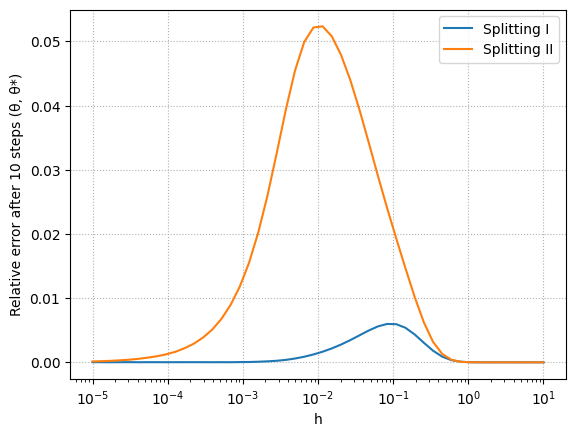

In [2]:
from matplotlib import pyplot as plt
for method in methods:
    plt.semilogx(hs, errs[method], label=method)
plt.xlabel("h")
plt.ylabel(f"Relative error after {n_timesteps} steps (θ, θ*)")
plt.grid(linestyle=":")
plt.legend()
plt.show()

# How different optimizers corresponds to the ODE trajectory

  0%|          | 0/4 [00:00<?, ?it/s]

Exact solution
SGD
n_epochs = 15
Splitting I
Splitting II


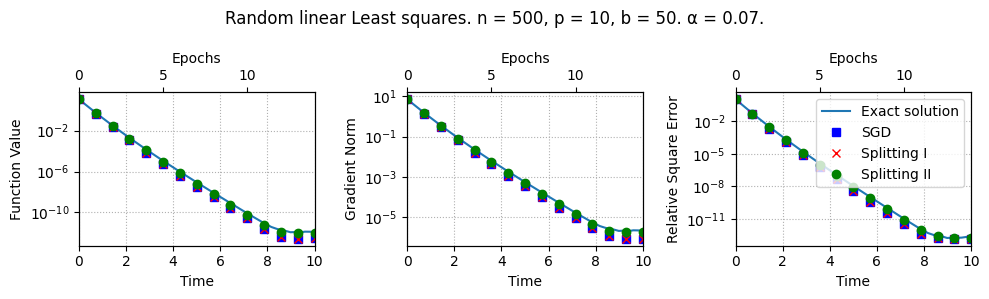

In [89]:
# ======= Libraries =======
import jax.numpy as jnp
import jax.random
import math
from jax import jit, vmap, grad
from jax.numpy.linalg import qr
from jax.scipy.linalg import expm
from jax.numpy.linalg import pinv
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import numpy as np

RNG = jax.random.PRNGKey(0)

# ======= Helper functions =======
def generate_problem(p, n, b, lstsq=False, epsilon=0, key=RNG):
    # Generate the main problem data
    X = jax.random.normal(key, (n, p))
    theta_clean = jnp.ones(p)
    y = X @ theta_clean + epsilon * jax.random.normal(key, (n,))
    init_bound = 1.0 / math.sqrt(p)
    theta_0 = init_bound * jax.random.uniform(key, (p,), minval=-1, maxval=1)

    # Split data into batches (ignoring the remainder if n is not divisible by b)
    m = n // b  # Number of full batches
    Xs = jnp.array([X[i * b:(i + 1) * b, :] for i in range(m)])
    ys = jnp.array([y[i * b:(i + 1) * b] for i in range(m)])

    # @jit
    def QR_dataset(Xs):
        # Perform QR decomposition for each batch
        Qs = jnp.array([qr(X_batch.T, mode='reduced')[0] for X_batch in Xs])
        Rs = jnp.array([qr(X_batch.T, mode='reduced')[1] for X_batch in Xs])
        return Qs, Rs

    Qs, Rs = QR_dataset(Xs)
    # Compute least squares solution if requested
    theta_lstsq = jnp.linalg.lstsq(X, y, rcond=None)[0] if lstsq else None

    # Store everything in a dictionary
    problem = {
        "Xs": Xs,
        "ys": ys,
        "Qs": Qs,
        "Rs": Rs,
        "X": X,
        "theta_0": theta_0,
        "theta_lstsq": theta_lstsq,
        "y": y,
        "n": n,
        "b": b,
        "p": p,
        "m": m
    }

    return problem

# @jit
def solve_local_problem(h, local_problem):
    # Using pinv by default as JAX does not support exceptions in JIT-compiled functions
    Q, R, theta_0, y, n = local_problem["Q"], local_problem["R"], \
        local_problem["theta_0"], local_problem["y"], local_problem["n"],
    
    R_it = pinv(R.T)
    exp_m = expm(-2 / n * R @ R.T * h)

    return Q @ (exp_m @ (Q.T @ theta_0 - R_it @ y)) + Q @ (R_it @ y) + theta_0 - Q @ (Q.T @ theta_0)

# @jit
def solve_local_problem_euler(h, local_problem):
    # Using pinv by default as JAX does not support exceptions in JIT-compiled functions
    X, y, theta_0, n = local_problem["X"], local_problem["y"], \
        local_problem["theta_0"], local_problem["n"]

    # print("X", X)
    # print("y", y)
    
    g_k = 2/n*X.T@(X@theta_0-y)
    # print("💎", g_k)
    # print("💎 Auto", grad(function_value, argnums=1)(X, theta_0, y))

    return theta_0 - h*g_k

# @jit
def function_value(X, theta, y):
    n = X.shape[0]
    return 1/n * jnp.linalg.norm(X @ theta - y)**2

# @jit
def gradient_norm(X, theta, y):
    gradient = 2/n * X.T @ (X @ theta - y)
    return jnp.linalg.norm(gradient)

# @jit
def relative_square_error(theta, theta_lstsq):
    return jnp.linalg.norm(theta - theta_lstsq)**2 / jnp.linalg.norm(theta_lstsq)**2

# ======= Experiment design =======

# Example usage
p = 10 # Number of parameters
n = 500  # Number of samples
b = 50   # Batch size
m = n//b
t_max = 10
h = 7e-1
learning_rate = h/m
n_epochs = int(t_max/h)
problem = generate_problem(p, n, b, lstsq=True, epsilon=0)
# print("🤖 problem", problem)

methods = ["Exact solution", "SGD","Splitting I", "Splitting II"]
fs, gs, errs, ts = \
    dict.fromkeys(methods), dict.fromkeys(methods), dict.fromkeys(methods), \
    dict.fromkeys(methods)

# ======= Experiment =======

for method in tqdm(methods):
    print(method)
    if method == "Exact solution":
        ts[method] = jnp.linspace(0, t_max)
        Q, R = qr(problem["X"].T, mode='reduced')

        local_problem = {
            "X": problem["X"],
            "y": problem["y"],
            "Q": Q,
            "R": R,
            "theta_0": problem["theta_0"],
            "n": problem["n"]
            }

        # Vectorizing the solve_local_problem function over timestamps
        v_solve_local_problem = vmap(solve_local_problem, in_axes=(0, None))

        # Calculate thetas for all timestamps in one go
        thetas = v_solve_local_problem(ts[method], local_problem)
    
    elif method == "SGD":
        t = 0
        ts[method] = []
        n_timesteps = int(jnp.floor(t_max/h)+1)
        thetas = np.zeros((n_timesteps, p))
        theta = problem["theta_0"]
        ts[method] = jnp.linspace(0, t_max, n_timesteps)
        thetas[0,: ] = theta
        print(f"n_epochs = {n_timesteps}")
        for i_t in range(n_timesteps-1):
            # print(theta)
            for i_batch in range(problem["m"]):
                # print("SUKA ys batch", problem["ys"][i_batch])
                # print("X", problem["Xs"][i_batch])
                # print("y", problem["ys"][i_batch])
                g_k = grad(function_value, argnums=1)(problem["Xs"][i_batch], 
                                                           theta, 
                                                           problem["ys"][i_batch])
                # print("💎", g_k)
                theta -= learning_rate*g_k
            thetas[i_t+1] = theta
    
    elif method == "Splitting I":
        t = 0
        ts[method] = []
        n_timesteps = int(jnp.floor(t_max/h)+1)
        thetas = np.zeros((n_timesteps, p))
        theta = problem["theta_0"]
        ts[method] = jnp.linspace(0, t_max, n_timesteps)
        thetas[0,: ] = theta
        for i_t in range(n_timesteps-1):
            # print(theta)
            for i_batch in range(problem["m"]):
                # print("SUKA ys batch", problem["ys"][i_batch])
                local_problem = {
                    "X": problem["Xs"][i_batch],
                    "y": problem["ys"][i_batch],
                    "Q": problem["Qs"][i_batch],
                    "R": problem["Rs"][i_batch],
                    "theta_0": theta,
                    "n": problem["n"]
                    }
                theta = solve_local_problem_euler(h, local_problem)


            thetas[i_t+1] = theta

    elif method == "Splitting II":
        t = 0
        ts[method] = []
        n_timesteps = int(jnp.floor(t_max/h)+1)
        thetas = np.zeros((n_timesteps, p))
        theta = problem["theta_0"]
        ts[method] = jnp.linspace(0, t_max, n_timesteps)
        thetas[0,: ] = theta
        for i_t in range(n_timesteps-1):
            # print(theta)
            for i_batch in range(problem["m"]):
                local_problem = {
                    "X": problem["Xs"][i_batch],
                    "y": problem["ys"][i_batch],
                    "Q": problem["Qs"][i_batch],
                    "R": problem["Rs"][i_batch],
                    "theta_0": theta,
                    "n": problem["n"]
                    }
                theta = solve_local_problem_euler(h/2, local_problem)
            
            for i_batch in range(problem["m"]-1, -1, -1):
                local_problem = {
                    "X": problem["Xs"][i_batch],
                    "y": problem["ys"][i_batch],
                    "Q": problem["Qs"][i_batch],
                    "R": problem["Rs"][i_batch],
                    "theta_0": theta,
                    "n": problem["n"]
                    }
                theta = solve_local_problem_euler(h/2, local_problem)

            thetas[i_t+1] = theta

    # Vectorizing the other functions
    v_function_value = vmap(function_value, in_axes=(None, 0, None))
    v_gradient_norm = vmap(gradient_norm, in_axes=(None, 0, None))
    v_relative_square_error = vmap(relative_square_error, in_axes=(0, None))

    # Compute the metrics for all timestamps
    fs[method] = v_function_value(problem["X"], thetas, problem["y"])
    gs[method] = v_gradient_norm(problem["X"], thetas, problem["y"])
    errs[method] = v_relative_square_error(thetas, problem["theta_lstsq"])



fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# Calculate the positions of the top x-axis ticks (for epochs) to align with the bottom x-axis (time)
# top_ticks_positions = np.linspace(0, t_max, n_epochs + 1)

for ax in axs:
    # Set the x-axis limits for the bottom x-axis to align with your time and epochs
    ax.set_xlim(0, t_max)

    # Create a secondary x-axis for each subplot
    ax_top = ax.twiny()
    # Adjust the limits of the top x-axis to align with the bottom x-axis
    ax_top.set_xlim(0, n_epochs)
    # Set the ticks for the new x-axis to represent epochs, aligning with the specified positions
    # ax_top.set_xticks(top_ticks_positions)
    # Set the labels for the new x-axis ticks to represent epochs from 0 to n_epochs
    # ax_top.set_xticklabels(np.arange(0, n_epochs + 1))
    ax_top.set_xlabel('Epochs')

for method in methods:
    if method == "Exact solution":
        linestyle = "-"
    elif method == "Splitting I":
        linestyle = "rx"
    elif method == "Splitting II":
        linestyle = "go"
    elif method == "SGD":
        linestyle = "bs"
    
    axs[0].semilogy(ts[method], fs[method], linestyle, label=method)
    # axs[0].set_title('Function Value over Time')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Function Value')
    axs[0].grid(linestyle=":")

    axs[1].semilogy(ts[method], gs[method], linestyle, label=method)
    # axs[1].set_title('Gradient Norm over Time')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Gradient Norm')
    axs[1].grid(linestyle=":")

    axs[2].semilogy(ts[method], errs[method], linestyle, label=method)
    # axs[2].set_title('Relative Square Error over Time')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Relative Square Error')
    axs[2].grid(linestyle=":")
    axs[2].legend()

plt.suptitle(f"Random linear Least squares. n = {n}, p = {p}, b = {b}. α = {learning_rate:.2f}.")
plt.tight_layout()
plt.show()


In [57]:
ax.get_xlim()

(-0.05, 1.05)

In [99]:
# ======= Libraries =======
import jax.numpy as jnp
import jax.random
import math
from jax import jit, vmap
from jax.numpy.linalg import qr
from jax.scipy.linalg import expm
from jax.numpy.linalg import pinv
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import scipy.io as sio

RNG = jax.random.PRNGKey(0)

# ======= Helper functions =======
def generate_tom_problem(key = RNG):
    # Generate the main problem data
    X = sio.loadmat("../lls_data/fanlinear.mat")["A"].toarray()
    theta_true = sio.loadmat("../lls_data/shepplogan.mat")["x"]
    n, p = X.shape
    y = np.squeeze(X @ theta_true)
    init_bound = 1.0 / math.sqrt(p)
    theta_0 = init_bound * jax.random.uniform(key, (p,), minval=-1, maxval=1)

    # Split data into batches (ignoring the remainder if n is not divisible by b)
    m = n // b  # Number of full batches
    Xs = jnp.array([X[i * b:(i + 1) * b, :] for i in range(m)])
    ys = jnp.array([y[i * b:(i + 1) * b] for i in range(m)])

    @jit
    def QR_dataset(Xs):
        # Perform QR decomposition for each batch
        Qs = jnp.array([qr(X_batch.T, mode='reduced')[0] for X_batch in Xs])
        Rs = jnp.array([qr(X_batch.T, mode='reduced')[1] for X_batch in Xs])
        return Qs, Rs

    Qs, Rs = QR_dataset(Xs)
    # Compute least squares solution if requested
    theta_lstsq = jnp.linalg.lstsq(X, y, rcond=None)[0]

    # Store everything in a dictionary
    problem = {
        "Xs": Xs,
        "ys": ys,
        "Qs": Qs,
        "Rs": Rs,
        "X": X,
        "theta_0": theta_0,
        "theta_lstsq": theta_lstsq,
        "y": y,
        "n": n,
        "b": b,
        "p": p,
        "m": m
    }

    return problem

@jit
def solve_local_problem(h, local_problem):
    # Using pinv by default as JAX does not support exceptions in JIT-compiled functions
    Q, R, theta_0, y, n = local_problem["Q"], local_problem["R"], \
        local_problem["theta_0"], local_problem["y"], local_problem["n"],
    
    R_it = pinv(R.T)
    exp_m = expm(-1 / n * R @ R.T * h)

    return Q @ (exp_m @ (Q.T @ theta_0 - R_it @ y)) + Q @ (R_it @ y) + theta_0 - Q @ (Q.T @ theta_0)

@jit
def function_value(X, theta, y, n):
    return 1/n * jnp.linalg.norm(X @ theta - y)**2

@jit
def gradient_norm(X, theta, y, n):
    gradient = 2/n * X.T @ (X @ theta - y)
    return jnp.linalg.norm(gradient)

@jit
def relative_square_error(theta, theta_lstsq):
    return jnp.linalg.norm(theta - theta_lstsq)**2 / jnp.linalg.norm(theta_lstsq)**2

# ======= Experiment design =======

# Example usage
p = 30  # Number of parameters
n = 100  # Number of samples
b = 20   # Batch size
t_max = 50
learning_rate = 5e-1
problem = generate_tom_problem()

methods = ["Exact solution", "Splitting I", "Splitting II"]
fs, gs, errs, ts = \
    dict.fromkeys(methods), dict.fromkeys(methods), dict.fromkeys(methods), \
    dict.fromkeys(methods)

# ======= Experiment =======

for method in tqdm(methods):
    print(method)
    if method == "Exact solution":
        ts[method] = jnp.linspace(0, t_max)
        Q, R = qr(problem["X"].T, mode='reduced')

        local_problem = {
            "X": problem["X"],
            "y": problem["y"],
            "Q": Q,
            "R": R,
            "theta_0": problem["theta_0"],
            "n": problem["n"]
            }

        # Vectorizing the solve_local_problem function over timestamps
        v_solve_local_problem = vmap(solve_local_problem, in_axes=(0, None))

        # Calculate thetas for all timestamps in one go
        thetas = v_solve_local_problem(ts[method], local_problem)
    
    elif method == "Splitting I":
        t = 0
        ts[method] = []
        n_timesteps = int(jnp.floor(t_max/learning_rate)+1)
        thetas = np.zeros((n_timesteps, p))
        theta = problem["theta_0"]
        ts[method] = jnp.linspace(0, t_max, n_timesteps)
        thetas[0,: ] = theta
        for i_t in range(n_timesteps-1):
            for i_batch in range(problem["m"]):
                local_problem = {
                    "X": problem["Xs"][i_batch],
                    "y": problem["ys"][i_batch],
                    "Q": problem["Qs"][i_batch],
                    "R": problem["Rs"][i_batch],
                    "theta_0": theta,
                    "n": problem["n"]
                    }
                theta = solve_local_problem(learning_rate, local_problem)

            thetas[i_t+1] = theta

    elif method == "Splitting II":
        t = 0
        ts[method] = []
        n_timesteps = int(jnp.floor(t_max/learning_rate)+1)
        thetas = np.zeros((n_timesteps, p))
        theta = problem["theta_0"]
        ts[method] = jnp.linspace(0, t_max, n_timesteps)
        thetas[0,: ] = theta
        for i_t in range(n_timesteps-1):
            for i_batch in range(problem["m"]):
                local_problem = {
                    "X": problem["Xs"][i_batch],
                    "y": problem["ys"][i_batch],
                    "Q": problem["Qs"][i_batch],
                    "R": problem["Rs"][i_batch],
                    "theta_0": theta,
                    "n": problem["n"]
                    }
                theta = solve_local_problem(learning_rate/2, local_problem)
            
            for i_batch in range(problem["m"]-1, -1, -1):
                local_problem = {
                    "X": problem["Xs"][i_batch],
                    "y": problem["ys"][i_batch],
                    "Q": problem["Qs"][i_batch],
                    "R": problem["Rs"][i_batch],
                    "theta_0": theta,
                    "n": problem["n"]
                    }
                theta = solve_local_problem(learning_rate/2, local_problem)

            thetas[i_t+1] = theta

    # Vectorizing the other functions
    v_function_value = vmap(function_value, in_axes=(None, 0, None, None))
    v_gradient_norm = vmap(gradient_norm, in_axes=(None, 0, None, None))
    v_relative_square_error = vmap(relative_square_error, in_axes=(0, None))

    # Compute the metrics for all timestamps
    fs[method] = v_function_value(problem["X"], thetas, problem["y"], problem["n"])
    gs[method] = v_gradient_norm(problem["X"], thetas, problem["y"], problem["n"])
    errs[method] = v_relative_square_error(thetas, problem["theta_lstsq"])

# ======= Plot the results =======
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

for method in methods:
    if method == "Exact solution":
        linestyle = "-"
    elif method == "Splitting I":
        linestyle = "rx"
    elif method == "Splitting II":
        linestyle = "go"
    
    axs[0].semilogy(ts[method], fs[method], linestyle, label=method)
    axs[0].set_title('Function Value over Time')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Function Value')
    axs[0].grid(linestyle=":")

    axs[1].semilogy(ts[method], gs[method], linestyle, label=method)
    axs[1].set_title('Gradient Norm over Time')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Gradient Norm')
    axs[1].grid(linestyle=":")

    axs[2].semilogy(ts[method], errs[method], linestyle, label=method)
    axs[2].set_title('Relative Square Error over Time')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Relative Square Error')
    axs[2].grid(linestyle=":")
    axs[2].legend()

plt.suptitle(f"TOM linear Least squares. n = {n}, p = {p}, b = {b}")
plt.tight_layout()
plt.show()

  0%|          | 0/3 [00:00<?, ?it/s]

Exact solution
